In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import cv2

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

In [40]:
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

dog.jpg exists


In [41]:
img = torchvision.io.read_image("dog.jpg")
print(img.shape)

torch.Size([3, 1365, 2048])


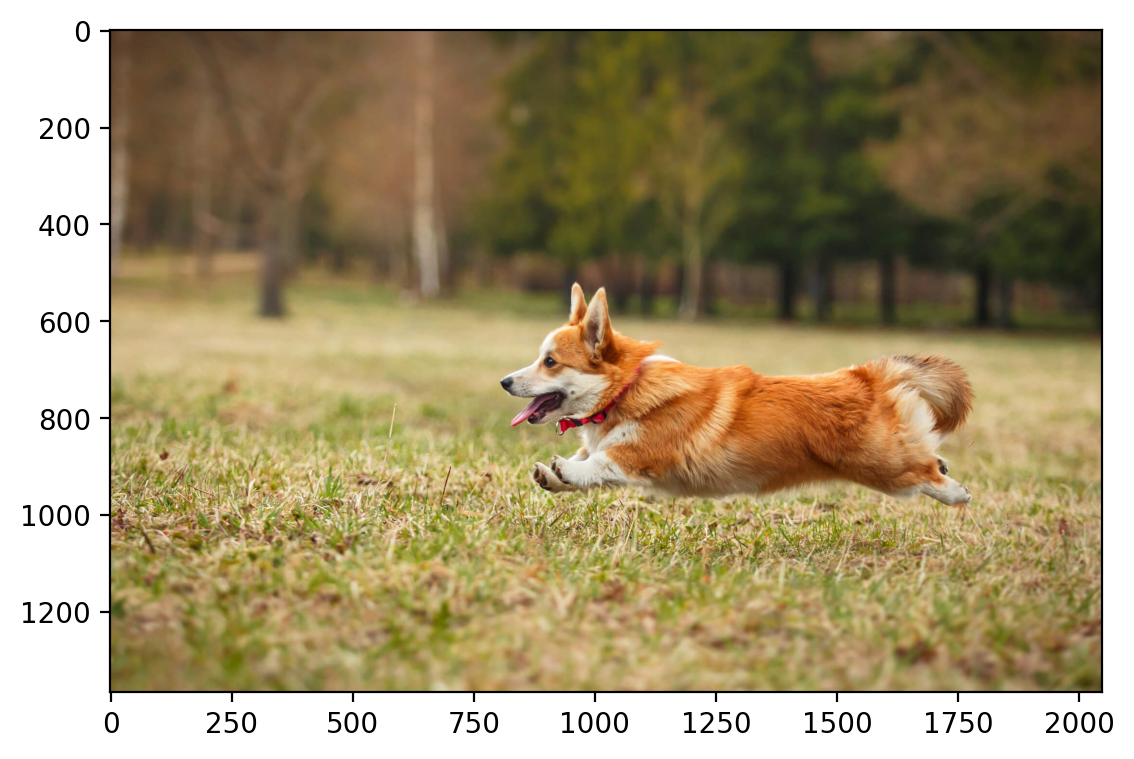

In [42]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [43]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [44]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape

img_scaled = torch.tensor(img_scaled)

In [45]:
img_scaled = img_scaled.to(device)
img_scaled

tensor([[[0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         ...,
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3765, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3804, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3843, 0.3804, 0.3804]],

        [[0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         ...,
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3176, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3216, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3255, 0.3216, 0.3216]],

        [[0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.

In [46]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 500, 750, 400, 400)
crop.shape

torch.Size([3, 400, 400])

In [48]:
# Convert the cropped tensor to a NumPy array
crop_np = crop.permute(1, 2, 0).numpy()  # Reorder dimensions to (H, W, C)

# Ensure that the NumPy array has pixel values in the range [0, 255] and is of type uint8
crop_np = (crop_np * 255).astype(np.uint8)

# Use OpenCV to resize the image
low_res_image = cv2.resize(crop_np, (200, 200), interpolation=cv2.INTER_AREA)


# Convert back to PyTorch tensor and reorder dimensions to (C, H, W)
crop2 = torch.from_numpy(low_res_image/255).permute(2, 0, 1)


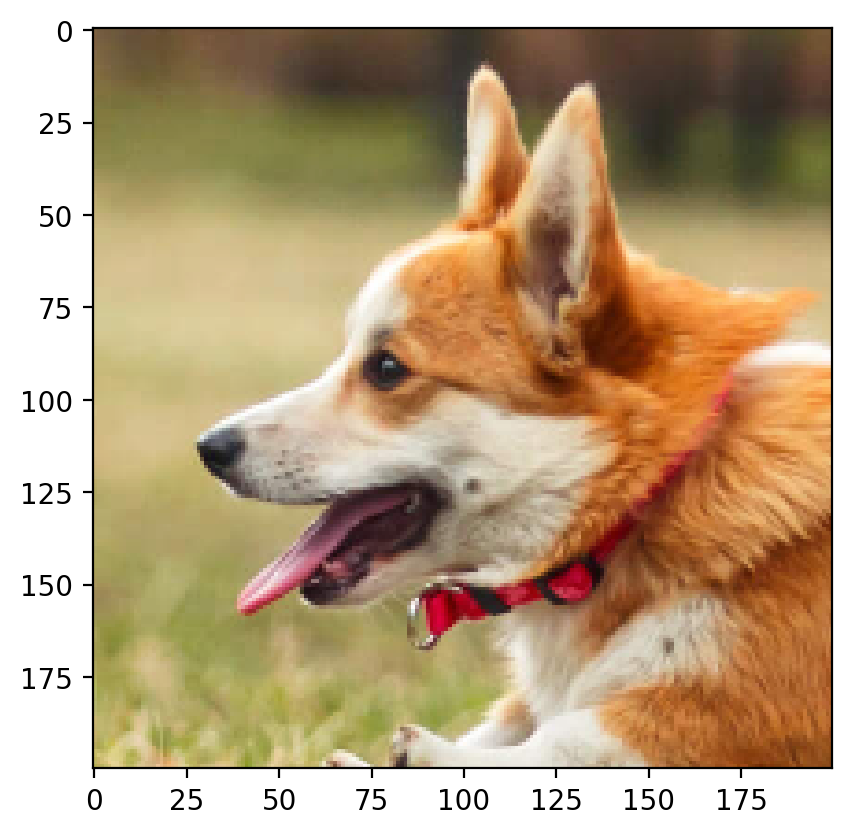

In [50]:
plt.imshow(rearrange(crop2 , 'c h w -> h w c').cpu().numpy())

In [51]:
crop2 = crop2.to(device)

## Question 1

In [52]:
def create_coordinate_map(img, scale=1):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(0, width,  1/scale).repeat(int(height*scale), 1)
    h_coords = torch.arange(0, height, 1/scale).repeat(int(width*scale), 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [53]:
resized_dog_X, resized_dog_Y = create_coordinate_map(crop2)

resized_dog_X.shape, resized_dog_Y.shape

(torch.Size([40000, 2]), torch.Size([40000, 3]))

In [54]:
# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(resized_dog_X.cpu())

# Scale the X coordinates
resized_dog_X_scaled = scaler_X.transform(resized_dog_X.cpu())

# Move the scaled X coordinates to the GPU
resized_dog_X_scaled = torch.tensor(resized_dog_X_scaled).to(device)

# Set to dtype float32
resized_dog_X_scaled = resized_dog_X_scaled.float()

In [55]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

In [56]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)


        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [57]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
        #outputs = outputs.permute(1, 2, 0)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")


    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")

    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

In [58]:
# create RFF features
def create_rff_features(X, num_features, sigma, random_state = None):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2),random_state=random_state)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

In [59]:
X_rff = create_rff_features(resized_dog_X_scaled, 10000, 0.008,77)
X_rff.shape

torch.Size([40000, 10000])

In [60]:
net = LinearModel(X_rff.shape[1], 3).to(device)
train(net, lr=0.005, X=X_rff, Y=resized_dog_Y, epochs=1000)

Epoch 0 loss: 0.319942
Epoch 100 loss: 0.049344
Epoch 200 loss: 0.022406
Epoch 300 loss: 0.018333
Epoch 400 loss: 0.016036
Epoch 500 loss: 0.014370
Epoch 600 loss: 0.013087
Epoch 700 loss: 0.012061
Epoch 800 loss: 0.011214
Epoch 900 loss: 0.010496


0.009880434721708298

In [61]:
#creating new coordinate map for 400*400 image
resized_2X,resized_2Y = create_coordinate_map(crop2, scale=2)

resized_2X.shape,resized_2Y.shape

(torch.Size([160000, 2]), torch.Size([40000, 3]))

In [62]:
# MinMaxScaler from -1 to 1
scaler_2X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(resized_2X.cpu())

# Scale the X coordinates
resized_2X_scaled = scaler_2X.transform(resized_2X.cpu())

# Move the scaled X coordinates to the GPU
resized_2X_scaled = torch.tensor(resized_2X_scaled)

# Set to dtype float32
resized_2X_scaled = resized_2X_scaled.float().to(device)


In [63]:
# Create RFF features for 400x400 coordinates
resized_2rff = create_rff_features(resized_2X_scaled, num_features=10000, sigma=0.008, random_state=77)
print(f"RFF features for 400x400 image: {resized_2rff.shape}")  # Added print

RFF features for 400x400 image: torch.Size([160000, 10000])


In [64]:

# Function to plot images side by side
def plot_images(reconst_img, resized_img, original_image, title=""):
    fig = plt.figure(figsize=(18, 6))  # Adjust the size as needed
    gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])

    ax0 = plt.subplot(gs[0])
    ax0.imshow(original_image.cpu().permute(1, 2, 0))
    ax0.set_title('Original Image')

    ax1 = plt.subplot(gs[1])
    ax1.imshow(resized_img.cpu().permute(1, 2, 0))
    ax1.set_title('Resized Image')

    ax2 = plt.subplot(gs[2])
    ax2.imshow(reconst_img.cpu().permute(0,1,2))
    ax2.set_title('Reconstructed Image')

    plt.suptitle(title)
    for a in [ax0, ax1, ax2]:
        a.axis("off")
    plt.show()


In [65]:
#function to calculate the output
def reconstructedOutput(resized_img,net, X):
    num_channels, height, width = resized_img.shape
    num_channels, height, width = num_channels, 2*height, 2*width
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
    return outputs

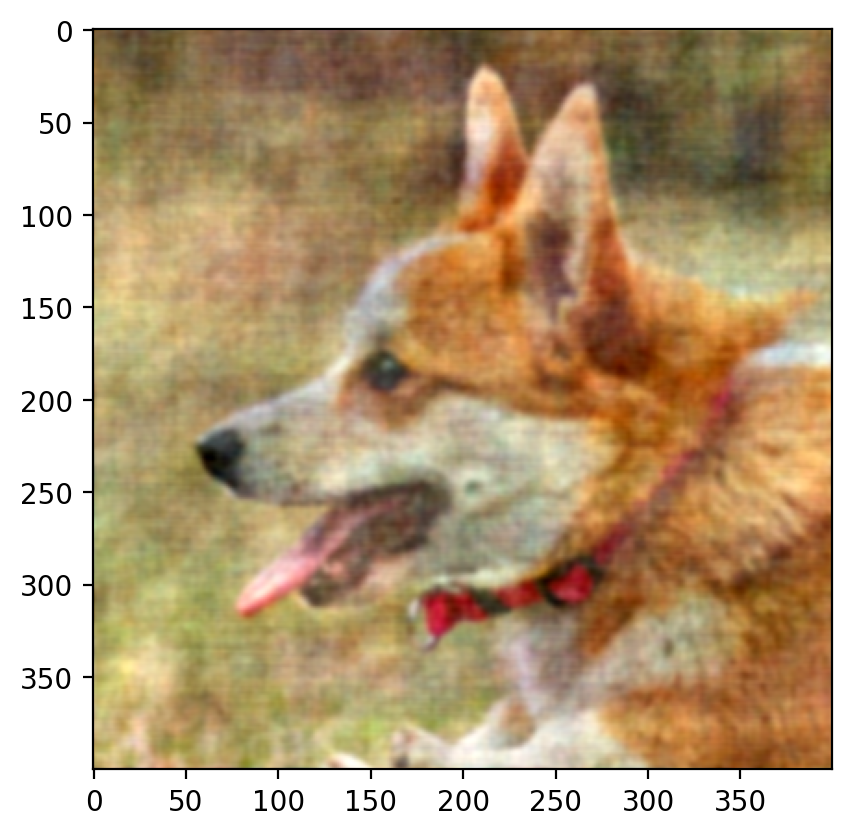

In [66]:
#Reconstruced image using resized image
reconst_crop = reconstructedOutput(crop2,net,resized_2rff)
crop_cpu = reconst_crop.cpu()
plt.imshow(crop_cpu.permute(0,1,2))
plt.show()


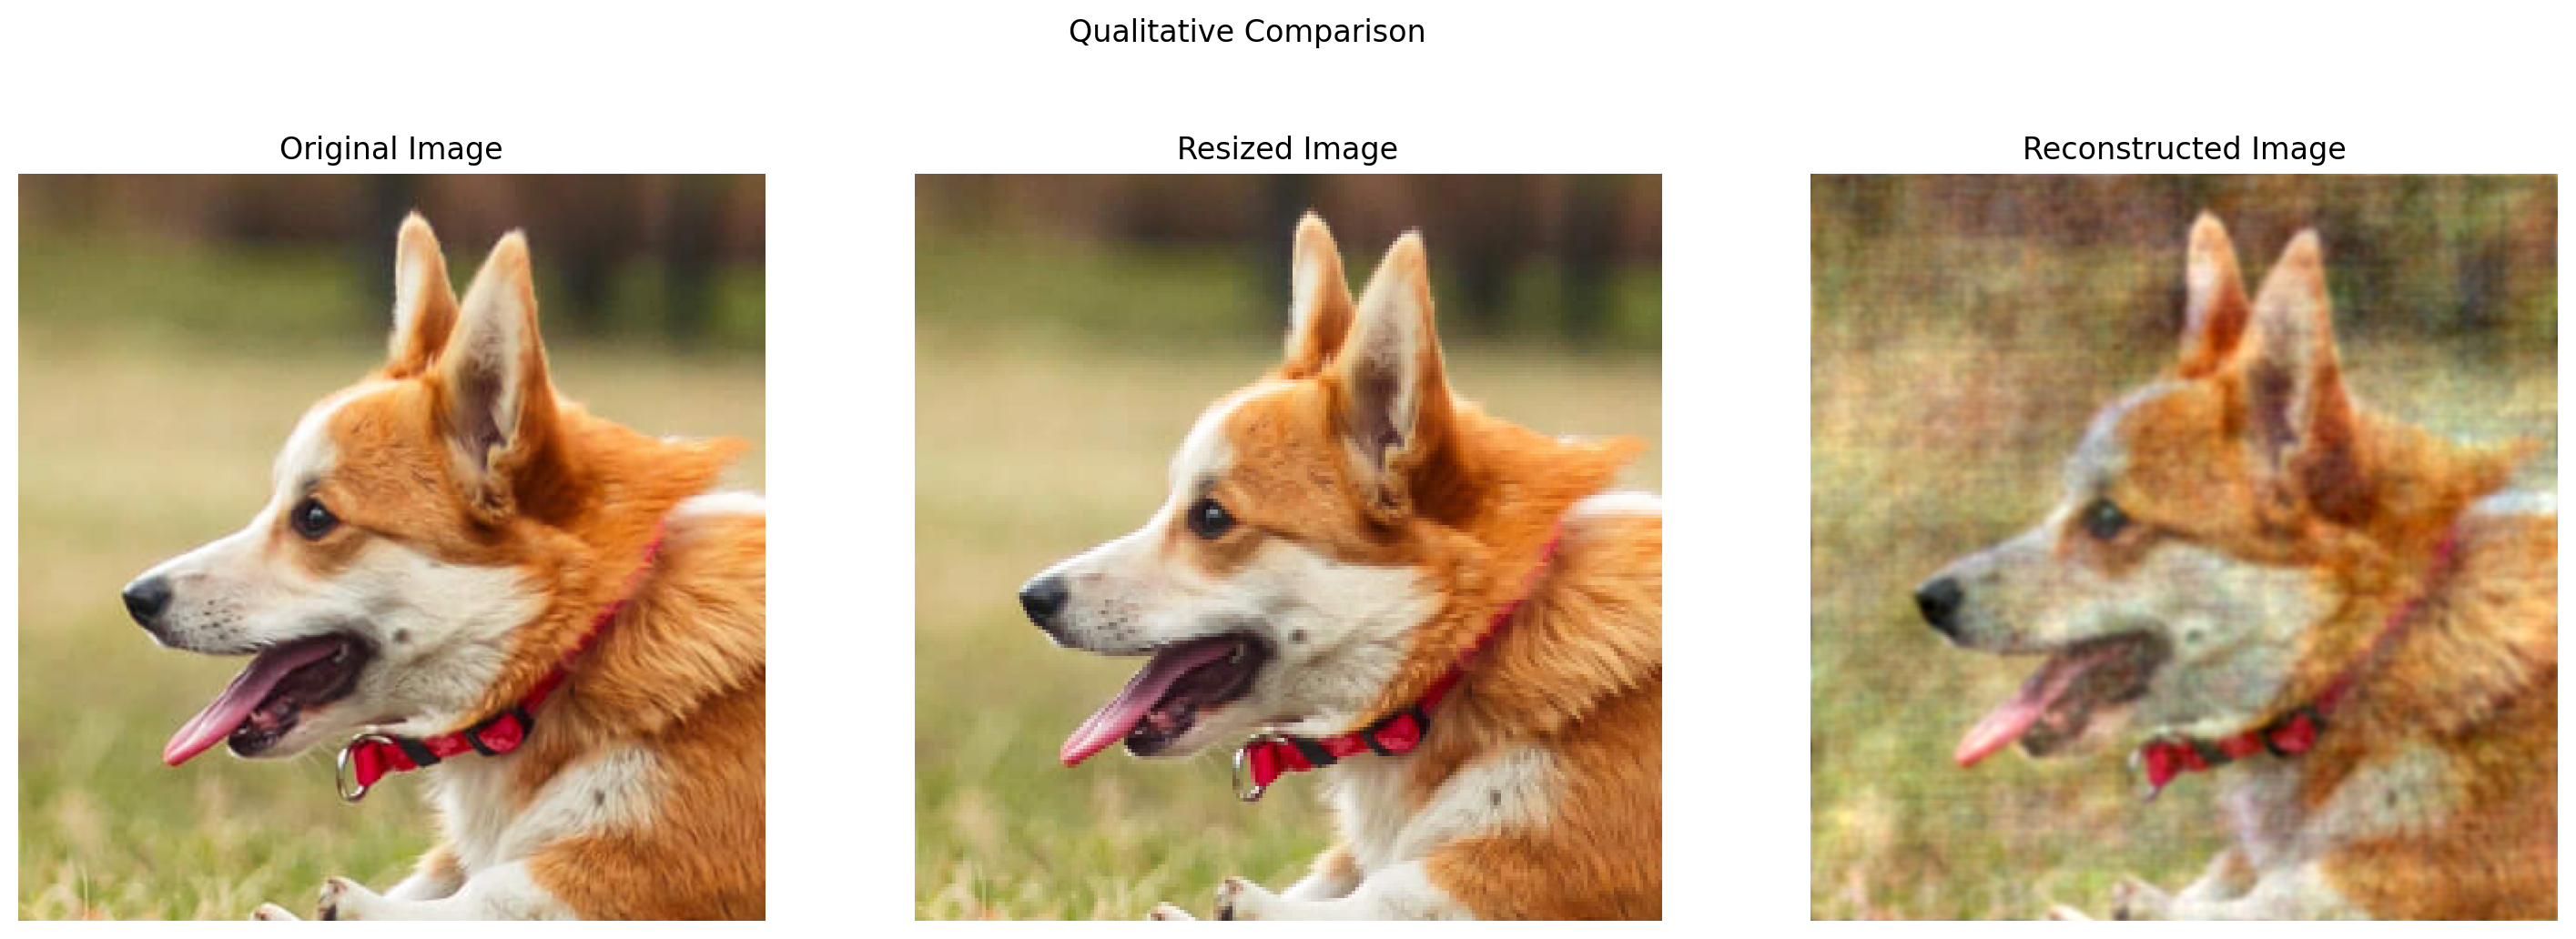

In [68]:
# Qualitative comparison
plot_images(reconst_crop.cpu(), crop2.cpu(), crop.cpu(), title="Qualitative Comparison")

## Question 2

In [69]:
def calculate_metrics(original, predicted):
    # Ensure both images are on the same scale
    diff = original.permute(1, 2, 0) - predicted
    mse = torch.mean(diff ** 2)

    # RMSE
    rmse = torch.sqrt(mse)
    print(f"RMSE: {rmse.item()}")

    # PSNR
    max_pixel_value = 1.0  # Since the images are normalized between 0 and 1
    psnr = 20 * torch.log10(max_pixel_value**2 / torch.sqrt(mse))
    print(f"PSNR: {psnr.item()} dB")
calculate_metrics(crop.cpu(), reconst_crop.cpu())

RMSE: 0.10057296064565978
PSNR: 19.950375300277678 dB


As we can observe from the PSNR metric, the Super-Resolution method gave better results than simple RFF + Linear Regression